In [25]:
using Pkg, Images, TestImages, CoordinateTransformations, Rotations, LinearAlgebra, Interpolations, SparseArrays, BenchmarkTools, FFTW
using BenchmarkTools, Images, Plots
#Pkg.activate("//Users/jiyong/External/GPUserver/development/Project/nTomo")
# Pkg.activate("/home/jiyong/development/Project/nTomo.jl")
using nTomo

# 1. Introduction

## 설치

우선 julia 언어를 설치하고 난 뒤

~~~julia
using Pkg
Pkg.add("https://github.com/Julia-KAERI/nTomo.jl.git")
~~~

를 이용해 `nTomo.jl` 을 설치한다. 


## nTomo.jl 의 좌표계

### 이미지의 좌표계

- `nTomo` 는 julia 언어 위에서 동작하는 패키지이다. 모든 이미지 데이터는 julia 의 `Array` 타입(혹은 `Matrix` 타입) 이며 `A` 가 이 이미지의 값을 저장하는 `Array` 변수라면 `A[i, j]` 형식으로 접근한다. 

- 기본적으로 행렬에서의 인덱스와 같은 방식을 사용하며, 따라서 $i$ 는 세로축의 인덱스, $j$ 는 가로축의 인덱스이다. 

- Julia 는 C 나 Python 과는 다르게 인덱스가 1 부터 시작한다. 2차원 배열 `A` 를 이미지로 표현하면 좌상단에 `A[1, 1]` 이 오며 $m \times n$ 2차원 배열일경우 `A[m, n]` 이 우하단이다. 아래의 그림을 보라.

<center>

![Shepp-Logan phantom](array_index.png){ width=60% }

</center>

</br>

### 토모그래피 좌표계

중성자 토모그래피는 평행빔 토모그래피이다. 여기서는 아래 그림과 같은 좌표계를 사용한다.

<center>

![Geometry of tomography](tomo_geo.png){ width=70% }

</center>

- 중성자 빔은 $y$ 축과 평행하다.

- 중성자 검출기는 $y=0$ 에 의해 결정되는 $xz$ 평면과 평행하다. 실제의 검출기는 렌즈나 광학에 의해 다른 위치에 있을지라도 검출기가 관측하는 평면이 $xz$ 평면과 평행하다는 의미이다.

- 토모그래피의 회전축은 $z$ 축과 평행하다.

- 회전각은 반시계방향의 각이 양수이다.


## 라돈 변환

다음의 그림을 보자. 이미지가 $0$ 에서 $1$ 사이의 값을 가지며 검은색이 $0$, 흰색이 $1$ 이라고 하자. 이 그림은 실제로 회색조 $1024 \times 1024$ 크기의 이미지이다. 이 이미지는 `f` 라는 배열의 변수로 저장되었다고 하자. $f(x, y)$ 라는 함수 나 `f[i, j]` 라는 형식의 배열로 이해해도 상관 없다.  

<center>

![object](object.png){ width=40% }

</center>

이 이미지를 $\theta$ 만큼 회전 시킨 이미지를 $\mathfrak{R}_\theta [f]$ 라고 하자.  아래 그림은 $\mathfrak{R}_{\pi/4}[f]$ 이다. 


<center>

![rotated object](rotated_object.png){ width=40% }

</center>

</br>

### Sinogram

아래와 같이 정의된 $S(x,\,\theta)$ 를 $f$ 에 대한 **sinogram** 이라고 한다. 


$$
S(x, \theta) =  \int \mathfrak{R}_\theta [f](x, y) \, dy
$$

즉 sinogram 은 2 차원 이미지, 혹은 함수를 회전시켜가며 한 방향(여기서는 $y$ 방향) 에 대한 선적분을 구하였을때 나오는 다른 방향과 회전각도에 대한 2차원 함수를 의미한다. 

Sinogram 을 그래프로 그리면 다음과 같다.

<center>

![sinogram](object_sinogram.png){ width=70% }

</center>


이 때 고정된 $\theta$ 에 대한 $S(x, \theta)$ 를 **projection** 이라고 하고 $P_\theta (t)$ 라고 표기한다. 즉 $P_\theta(t) =  S(t, \theta)$ 이다. 

</br>

### Fourier slice theorem 

Projection-slice theorem 혹은 central slice theorem 이라고도 한다. 이 정리는 $S(x, \theta)$ 로부터 $f(x,\,y)$ 를 얻을 수 있음을 보장한다. 


</br>

## 토모그래피


토모그래피의 기본적인 개념은 아래 그림과 같다. 중성자나 X 선과 같이 물질을 투과하는 성질이 강한 입자를 물질에 쐬어 주면 대부분의 입자가 물질을 투과하여 검출기에 검출된다. 하지만 모든 입자가 투과하지는 못하며 물질의 성질에 따라 일부 입자가 산란되거나 흡수되며 

![Tomography](tomography.png){ width=60% }
1``


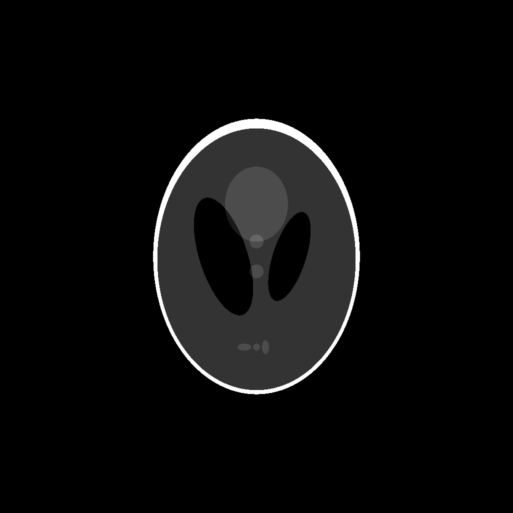

In [24]:
img = phantom_shepp_logan(600, 212)
s = mat2gray(img)
# save("shepp_logan.png", s)

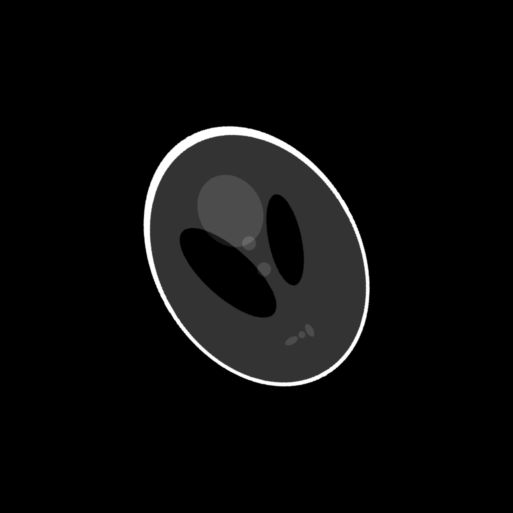

In [23]:
function _rotimg(img::Matrix{T}, θ, c=Union{Real, Nothing}=nothing) where T<:AbstractFloat
    m, n = size(img)
    if c === nothing
        img_center = (m>>1, n>>1)
    else 
        img_center = (c[1], c[2])
    end
    θ = θ/180.0*π
    mv, Mv = extrema(img)
    timg = Gray.((img.-mv)/(Mv-mv))
    trfm = recenter(RotMatrix(θ), img_center)
    img1 = warp(timg, inv(trfm), method=BSpline(Linear()), fillvalue = Flat(), axes(timg))
    result = T.((img1[1:m, 1:n]).*(Mv-mv) .+ mv)
    return result
end

r1 = _rotimg(img, 30, nothing)
mat2gray(r1)

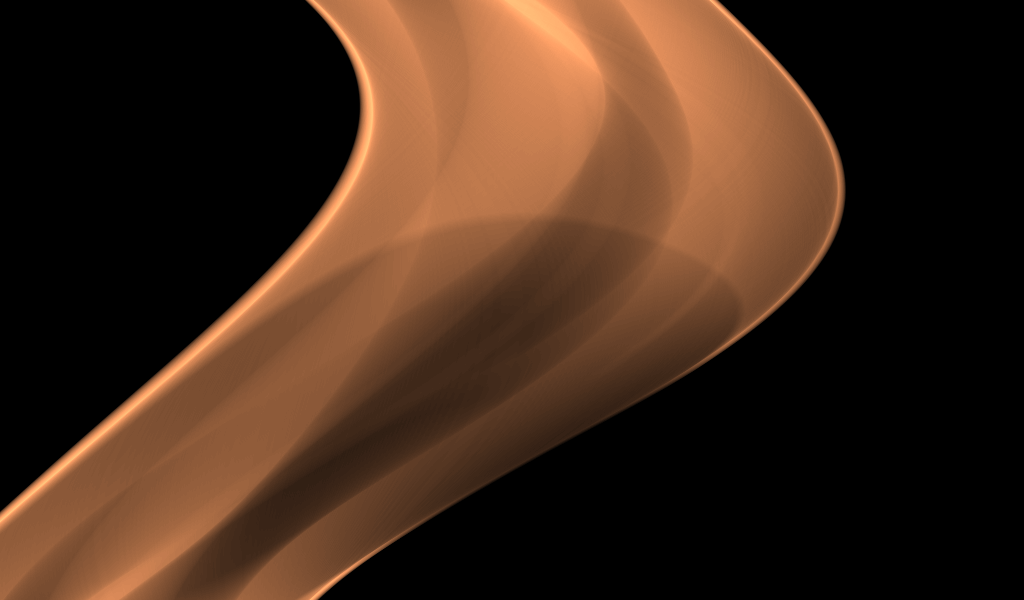

In [13]:
ths = 0.0:0.3:179.9
sino1 = radon(img, ths, (312, 312));
colorize(sino1, :copper)

# Filtered back projection 을 이용한 tomography reconstruction


</br>

- 가장 유명한 팬텀인 Shepp-logan phantom 을 사용하여 image reconstruction 을 테스트해본다. 아래의 `phantom_shepp_logan` 함수는 `Images.jl` 에서 제공하는 팬텀을 약간 변형시킨 것이다.


In [ ]:
rec1=iradon_fbp(sino1, ths, 512, "hann")
mat2gray(rec1)

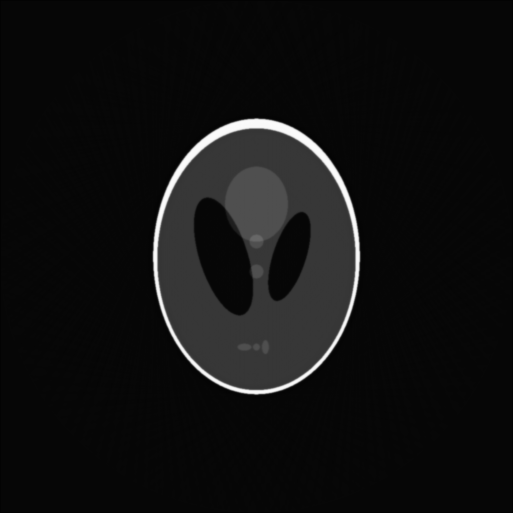

In [18]:
rec1=iradon_sart(sino1, ths, image = nothing, center = 512)
mat2gray(rec1)